<div style="position:relative; width:100%; height:100px;">
  <img src="https://raw.githubusercontent.com/stefanlessmann/VHB_ProDoc_ML/master/banner-nb.png" style="width:100%; object-fit:cover;" alt="ProDok-MachineLearning-Banner">
  <div style="
      position:absolute;
      left:4%;
      top:50%;
      transform:translateY(-50%);
      font-size:3.2vw;
      font-weight:750;
      color:#1f2a44;">
    ProDok – Machine Learning
  </div>
</div>

# todo fix colab batch 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stefanlessmann/VHB_ProDoc_ML/blob/master/P.I.2.cs_benchmark_solution.ipynb)

# New version

In [ ]:
# ============================================================
# Core scientific stack
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
RANDOM_STATE = 1803
np.random.seed(RANDOM_STATE)

# ============================================================
# Dataset loading (raw IMDB reviews)
# ============================================================
from datasets import load_dataset

# ============================================================
# Text cleaning
# ============================================================
import re
from bs4 import BeautifulSoup  # HTML removal
import lxml
import spacy
# Uncomment the line below when running in Google Colab or first-time setup
!python -m spacy download en_core_web_sm

# ============================================================
# sklearn utilities for vectorization, modeling, and evaluation
# ============================================================
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report
)

# ============================================================
# Dictionary-based sentiment analysis (lexicon baseline)
# ============================================================
# UNCOMMENT THIS LINE TO INSTALL VADER; NEEDED FOR COLAB
# ! pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ============================================================
# Hugging Face sentiment pipeline (Transformer-based)
# ============================================================
from transformers import pipeline

# ============================================================
# Supress Hugging Face warnings 
# ============================================================
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'


# IMDB Movie Review Dataset

In [2]:
# ----------------------------
# 1) Load data: Raw IMDB reviews
# ----------------------------
ds = load_dataset("imdb")

# Hugging Face datasets provide pre-defined train/test splits
train_text = ds["train"]["text"]
train_y = np.array(ds["train"]["label"], dtype=int)

test_text = ds["test"]["text"]
test_y = np.array(ds["test"]["label"], dtype=int)

print("Train:", len(train_text), "Test:", len(test_text))
print("Label distribution (train):", np.bincount(train_y))
print("Label distribution (test): ", np.bincount(test_y))


Train: 25000 Test: 25000
Label distribution (train): [12500 12500]
Label distribution (test):  [12500 12500]


In [8]:

# Inspect a couple of samples
examples = [888, 18] 
for j in i:
    print(train_text[examples])
    print("label:", train_y[examples])

["John Candy. Need we say more? He is the main reason you should see this film. Most people don't realize how gifted he was as an actor. Witness him changing from poor slob to horny jerk. Just a simple(subtle) facial change and off we go. There are many great bits in this movie and many really dumb bits. The best moments for me are the KUNG FU U scenes as well as the great moment when John(in a trance) goes up on stage and talks about how much he loves his girlfriend-that is how much he and his genitals love his girlfriend. I'm sure reading this you might think this sequence sounds really crude. It is, but it is also very funny mainly because it is John Candy doing this bit. The story in general is pretty lame and Eugene Levy and Joe Flaherty(both SCTV alumni with Candy) are not given enough to do in the film. Levy has his moments, especially filming the wedding at the end(think Rod Serling) and the great scene when he is talking to his mother on the phone. Overall a good movie if you 

In [14]:
# ----------------------------
# 2) Traditional text cleaning illustration
# ----------------------------
# Design goal: keep it transparent (students can understand each transformation)
nlp = spacy.load("en_core_web_sm")  # english stopwords; also needed for later tokenization
stop_words = nlp.Defaults.stop_words
HTML_PARSER = "lxml"  # if not installed, BeautifulSoup falls back; install lxml for speed/robustness

_whitespace_re = re.compile(r"\s+")
_nonword_re = re.compile(r"[^a-zA-Z0-9\s]")  # keep letters/numbers/spaces

def strip_html(text: str) -> str:
    # IMDB contains lots of <br /> tags etc.
    return BeautifulSoup(text, HTML_PARSER).get_text(" ")

def remove_stopwords(text: str) -> str:
    """Remove stopwords from normalized text."""
    return ' '.join([word for word in text.split() if word not in stop_words])


def basic_normalize(text: str) -> str:
    text = text.lower()
    text = _nonword_re.sub(" ", text)
    text = _whitespace_re.sub(" ", text).strip()
    return text

def clean_text(text: str) -> str:
    text = strip_html(text)
    text = basic_normalize(text)
    text = remove_stopwords(text)  # Add this line
    return text
    

# Demo on a few examples
for j in examples:
    raw = train_text[j]
    cleaned = clean_text(raw)
    print("\n--- CLEANING DEMO", j, "---")
    print("RAW:    ", raw[:250].replace("\n", " "))
    print("CLEANED:", cleaned[:250])


--- CLEANING DEMO 888 ---
RAW:     John Candy. Need we say more? He is the main reason you should see this film. Most people don't realize how gifted he was as an actor. Witness him changing from poor slob to horny jerk. Just a simple(subtle) facial change and off we go. There are man
CLEANED: john candy need main reason film people don t realize gifted actor witness changing poor slob horny jerk simple subtle facial change great bits movie dumb bits best moments kung fu u scenes great moment john trance goes stage talks loves girlfriend g

--- CLEANING DEMO 18 ---
RAW:     I think I will make a movie next weekend. Oh wait, I'm working..oh I'm sure I can fit it in. It looks like whoever made this film fit it in. I hope the makers of this crap have day jobs because this film sucked!!! It looks like someones home movie an
CLEANED: think movie weekend oh wait m working oh m sure fit looks like film fit hope makers crap day jobs film sucked looks like someones home movie don t think 100 s

In [ ]:
# Apply cleaning (sub-sample for speed)
SUBSAMPLE_TRAIN = 10000  #  (None for full dataset)
SUBSAMPLE_TEST = 5000   #  (None for full dataset)

if SUBSAMPLE_TRAIN is not None:
    idx = np.random.RandomState(RANDOM_STATE).choice(len(train_text), size=SUBSAMPLE_TRAIN, replace=False)
    train_text_sub = [train_text[i] for i in idx]
    train_y_sub = train_y[idx]
else:
    train_text_sub = list(train_text)
    train_y_sub = train_y

if SUBSAMPLE_TEST is not None:
    idx = np.random.RandomState(RANDOM_STATE + 1).choice(len(test_text), size=SUBSAMPLE_TEST, replace=False)
    test_text_sub = [test_text[i] for i in idx]
    test_y_sub = test_y[idx]
else:
    test_text_sub = list(test_text)
    test_y_sub = test_y

train_clean = [clean_text(t) for t in train_text_sub]
test_clean = [clean_text(t) for t in test_text_sub]

print("Cleaned train/test:", len(train_clean), len(test_clean))

Cleaned train/test: 10000 5000


BoW demo vocab size: 51340


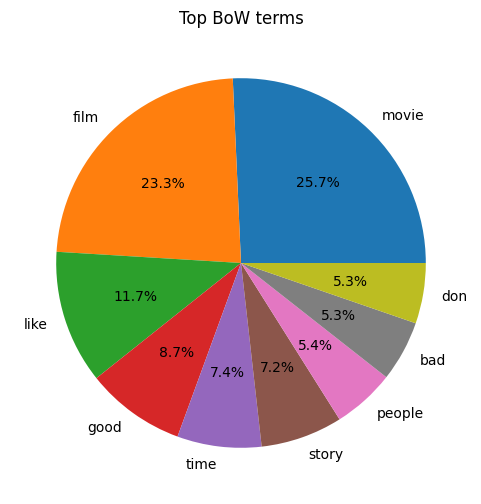

In [27]:
# ----------------------------
# 2b) Optional: Show Bag-of-Words artifacts (tokenization, vocabulary)
# ----------------------------
# This is pedagogically useful to illustrate what BoW "means".

bow_demo = CountVectorizer()

X_demo = bow_demo.fit_transform(train_clean)  
vocab_size = len(bow_demo.vocabulary_)
print("BoW demo vocab size:", vocab_size)

# Show the most frequent terms (approx; CountVectorizer keeps counts)
term_counts = np.asarray(X_demo.sum(axis=0)).ravel()
terms = np.array(bow_demo.get_feature_names_out())
top = np.argsort(-term_counts)[:9]

# show the top-10 terms as a piechart
plt.figure(figsize=(6, 6))
plt.pie(term_counts[top], labels=terms[top], autopct="%1.1f%%")
plt.title("Top BoW terms")
plt.show()


# Sentiment classification: positive vs. negative reviews

In [19]:
# ----------------------------
# Helper: Evaluation utilities (AUC + accuracy + ROC plot)
# ----------------------------
def eval_binary(y_true, y_score, threshold=0.5, title="Model"):
    """
    y_score: positive-class probability/score (higher => more positive)
    """
    auc = roc_auc_score(y_true, y_score)
    y_pred = (y_score >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    print(f"{title} | AUC={auc:.4f} | ACC={acc:.4f} | threshold={threshold}")

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4))

    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC: {title} (AUC={auc:.3f})")
    plt.show()

    return {"auc": auc, "acc": acc}

## Dictionary-based sentiment analysis (VADER)

Lexicon baseline (VADER) | AUC=0.7796 | ACC=0.6792 | threshold=0.5

Classification report:
              precision    recall  f1-score   support

           0     0.7959    0.4820    0.6004      2500
           1     0.6285    0.8764    0.7320      2500

    accuracy                         0.6792      5000
   macro avg     0.7122    0.6792    0.6662      5000
weighted avg     0.7122    0.6792    0.6662      5000



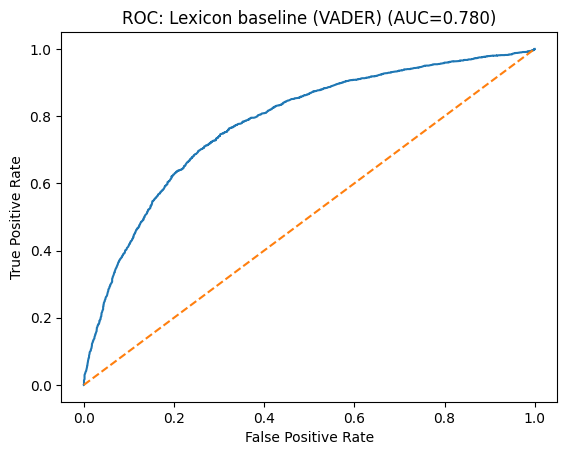

In [20]:
# ----------------------------
# 3) Dictionary-based sentiment analysis (VADER)
# ----------------------------
# VADER returns a "compound" score in [-1, 1].
# We'll convert to a [0, 1] score for AUC convenience.

vader = SentimentIntensityAnalyzer()
results = {}
def vader_score(text: str) -> float:
    s = vader.polarity_scores(text)["compound"]  # [-1, 1]
    return 0.5 * (s + 1.0)                       # map to [0, 1]

# Compute scores on cleaned text
vader_test_score = np.array([vader_score(t) for t in test_clean], dtype=float)

results["vader"] = eval_binary(test_y_sub, vader_test_score, threshold=0.5, title="Lexicon baseline (VADER)")

## Traditional ML-based sentiment classification (TF-IDF + Logistic Regression)

TF-IDF + L1 Logistic Regression | AUC=0.9243 | ACC=0.8424 | threshold=0.5

Classification report:
              precision    recall  f1-score   support

           0     0.8630    0.8140    0.8378      2500
           1     0.8240    0.8708    0.8468      2500

    accuracy                         0.8424      5000
   macro avg     0.8435    0.8424    0.8423      5000
weighted avg     0.8435    0.8424    0.8423      5000



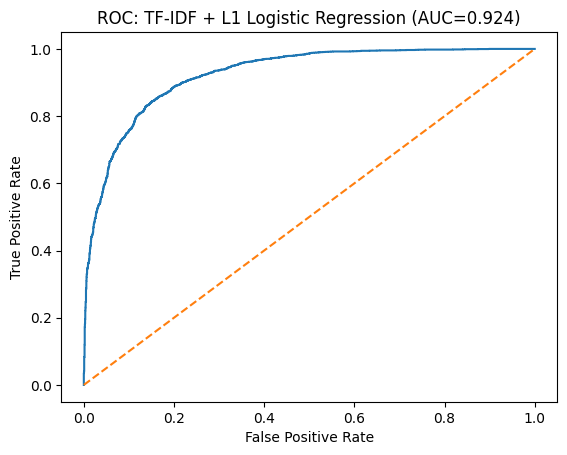

In [30]:
# ----------------------------
# 4) Traditional ML sentiment analysis: TF-IDF + L1 Logistic Regression (LASSO-style)
# ----------------------------
l1_logreg = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        stop_words="english",
        ngram_range=(1, 2),      # use unigrams + bigrams -> often strong for sentiment classification
        min_df=2,
        max_df=0.9,
    )),
    ("clf", LogisticRegression(
        penalty="l1",
        solver="saga",
        C=1.0,                   # smaller => stronger regularization
        max_iter=2000,
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

l1_logreg.fit(train_clean, train_y_sub)

# Predict probabilities for the positive class (label=1)
ml_test_score = l1_logreg.predict_proba(test_clean)[:, 1]
results["l1_logreg"] = eval_binary(test_y_sub, ml_test_score, threshold=0.5, title="TF-IDF + L1 Logistic Regression")

# this is yet to check

In [31]:
# ----------------------------
# 4b) Optional: Show "what did the model learn?" (top positive/negative features)
# ----------------------------
# Only works if the classifier exposes coef_ and we can access vectorizer feature names.

tfidf = l1_logreg.named_steps["tfidf"]
clf = l1_logreg.named_steps["clf"]
feature_names = tfidf.get_feature_names_out()
coef = clf.coef_.ravel()

top_pos = np.argsort(-coef)[:20]
top_neg = np.argsort(coef)[:20]

print("\nTop positive features:")
print(list(zip(feature_names[top_pos], coef[top_pos])))

print("\nTop negative features:")
print(list(zip(feature_names[top_neg], coef[top_neg])))


Top positive features:
[('excellent', np.float64(14.76349635414577)), ('great', np.float64(14.09027251166964)), ('best', np.float64(12.039358086052562)), ('perfect', np.float64(11.104992163072552)), ('amazing', np.float64(10.765404120117438)), ('wonderful', np.float64(9.634034127744876)), ('brilliant', np.float64(9.433234623592584)), ('wonderfully', np.float64(7.462502287550267)), ('hilarious', np.float64(7.324687079426516)), ('gem', np.float64(7.268370175736884)), ('today', np.float64(7.006256277841812)), ('fantastic', np.float64(6.906439696267934)), ('definitely', np.float64(6.901613159050232)), ('terrific', np.float64(6.767191813434542)), ('love', np.float64(6.442860066834861)), ('beautiful', np.float64(6.317910003431689)), ('10 10', np.float64(6.287379267171097)), ('favorite', np.float64(6.270075377156625)), ('enjoyed', np.float64(6.269667804338447)), ('enjoyable', np.float64(6.1671437807058425))]

Top negative features:
[('worst', np.float64(-27.70356299672227)), ('waste', np.flo

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

HF pipeline (DistilBERT SST-2) | AUC=0.9561 | ACC=0.8895 | threshold=0.5

Classification report:
              precision    recall  f1-score   support

           0     0.8561    0.9359    0.8942       998
           1     0.9296    0.8433    0.8844      1002

    accuracy                         0.8895      2000
   macro avg     0.8928    0.8896    0.8893      2000
weighted avg     0.8929    0.8895    0.8893      2000



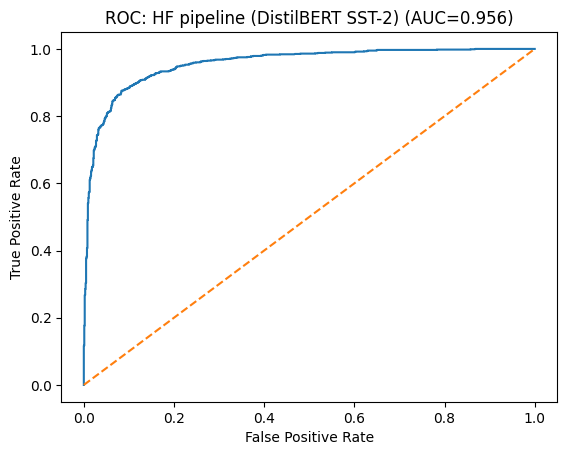

In [33]:
# ----------------------------
# 5) Hugging Face pipeline sentiment analysis (easiest possible)
# ----------------------------
# Default choice: SST-2 fine-tuned DistilBERT (binary).
# Note: domain mismatch (movie reviews vs SST-2) is a useful discussion point.
hf = pipeline(
    task="sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    return_all_scores=False  
)

def hf_positive_score(output_scores) -> float:
    """
    output_scores: list of dicts like [{"label": "NEGATIVE", "score": ...}, {"label": "POSITIVE", "score": ...}]
    We return P(POSITIVE).
    """
    # Make it robust to ordering
    for d in output_scores:
        if d["label"].upper() == "POSITIVE":
            return float(d["score"])
    # fallback: if labels differ, return max score (shouldn't happen in SST-2 pipeline)
    return float(max(d["score"] for d in output_scores))

# For speed in class, consider using only a subset of the test set for HF
HF_MAX_EXAMPLES = 2000  # set to None for full test (can be slow)
hf_texts = test_text_sub if HF_MAX_EXAMPLES is None else test_text_sub[:HF_MAX_EXAMPLES]
hf_y = test_y_sub if HF_MAX_EXAMPLES is None else test_y_sub[:HF_MAX_EXAMPLES]

# IMPORTANT: Transformers has max sequence length; truncation keeps it simple.
# We'll batch to speed things up.
HF_BATCH_SIZE = 32
hf_scores = []
for start in range(0, len(hf_texts), HF_BATCH_SIZE):
    batch = hf_texts[start:start + HF_BATCH_SIZE]
    out = hf(batch, truncation=True)
    # Now out is a list of single dicts like [{"label": "POSITIVE", "score": 0.95}, ...]
    hf_scores.extend([float(o["score"]) if o["label"] == "POSITIVE" else 1.0 - float(o["score"]) for o in out])

hf_scores = np.array(hf_scores, dtype=float)

results["hf_pipeline"] = eval_binary(hf_y, hf_scores, threshold=0.5, title="HF pipeline (DistilBERT SST-2)")

In [34]:
# ----------------------------
# 6) Comparison summary
# ----------------------------
summary = (
    pd.DataFrame(results)
      .T.rename_axis("model")
      .reset_index()
      .sort_values(["auc", "acc"], ascending=False)
)

summary

,model,auc,acc
2,hf_pipeline,0.956089,0.8895
1,l1_logreg,0.924293,0.8424
0,vader,0.779601,0.6792


## P.II.2 Fundamentals of natural language processing (NLP)
Pre-processing textual data is a standard task. Several Python libraries including `scikit-learn` and `Keras` offer similar functionality. We will use the `NLTK toolkit` in this notebook. It has a clear and easy to understand syntax and is well-suited to demonstrate standard NLP operations. Although not the focus of this tutorial, we also introduce a library called `Beautiful Soup`, which gained a lot of popularity in web-scraping. Make sure to have these libraries installed before running the following codes. 
Here is the agenda of the session:

1. Preparing text for analysis: the standard NLP pipeline
2. Use case: the IMDB movie review data set
3. Demo: training word-to-vec word embeddings

In [1]:
import numpy as np
# Library for standard NLP workflow
import nltk  # When running this notebook for the first time, you have to download the following NLTK packages. Just uncomment the next 3 lines
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('omw-1.4')

### 1. Preparing text for analysis: the standard NLP pipeline
To illustrate standard NLP preprocessing operations, we need some demo text. Below is an extract from a famous book; no need to quote I guess 😉

In [10]:
text_raw = """ 
I wonder if I have been changed in the night. Let me think. Was I the same when I got up this morning? 
I almost can remember feeling a little different. But if I am not the same, the next question is 'Who in the world am I?' 
Ah, that is the great puzzle!
"""
print(text_raw)

 
I wonder if I have been changed in the night. Let me think. Was I the same when I got up this morning? 
I almost can remember feeling a little different. But if I am not the same, the next question is 'Who in the world am I?' 
Ah, that is the great puzzle!



In the following parts, we incrementally build the functionality for a full preprocessing chain. To be able to nicely put everything together in the end, we will wrap up every piece of functionality that we build in a custom function.

#### Remove line breaks
Our first step of cleaning involves removing line breaks to obtain one - long - chunk of text. 

In [11]:
def remove_whitespace(text):
    """ Function to remove whitespace (tabs, newlines). """
    return ' '.join(text.split())

text_processed = remove_whitespace(text_raw)
print(text_processed)

I wonder if I have been changed in the night. Let me think. Was I the same when I got up this morning? I almost can remember feeling a little different. But if I am not the same, the next question is 'Who in the world am I?' Ah, that is the great puzzle!


Hm, but the punctuation is there still. Is it noise or is it useful? Let's try removing it for now (there is a bunch of methods out there). Additionally we will drop weird symbols and lower the big cases.


#### Punctuation Whitespace and Casing

In [12]:
def remove_punctuation_and_casing(text):
    """
    Function to remove the punctuation, upper casing and words that include
    non-alphanumeric characters.
    """
    chars = '!\"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
    text = text.translate(str.maketrans(chars, ' ' * len(chars)))
    return ' '.join([word.lower() for word in text.split() if word.isalpha()])

text_processed = remove_punctuation_and_casing(text_processed)
print(text_processed)

i wonder if i have been changed in the night let me think was i the same when i got up this morning i almost can remember feeling a little different but if i am not the same the next question is in the world am i ah that is the great puzzle


This is starting to look like a bag of words, right? There are some more issues we want to address though. Like 'stop words' - semantically they do not mean much but serve to put sentences together ("the", "a", "and", etc) - they will add noise. `NLTK` can offer you its own list of stop words.

#### Stopwords

In [13]:
# Remove stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
stop_words[0:9]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you']

In [14]:
len(stop_words)

179

The list of stop words looks comprehensive. However, say you miss a 'stop word' that you would also like to filter. You can extend the above list easily. After all, it is just a list.

In [15]:
t = type(stop_words)
print('Data type of stopwords is:', t ) 

Data type of stopwords is: <class 'list'>


In [16]:
# Add some custom stopwords
stop_words.append('some_word_you_dont_like')  # you can apply all the functions for lists
stop_words[-1]

'some_word_you_dont_like'

Finally, let's remove the stopwords from our processed sample text.

In [18]:
def remove_stopwords(text):
    """ Function to remove stopwords. """
    return ' '.join([word for word in str(text).split() if word not in stop_words])

text_processed = remove_stopwords(text_processed)
print(text_processed)

wonder changed night let think got morning almost remember feeling little different next question world ah great puzzle


Quite a reduction in the number of tokens by filtering stopwords, correct? Recall that the number of unique tokens plays a key role in the bag of word model. For example, representing text in the form of a document term matrix (DTM), the dimensionality of the DTM will be equal to the number of distinct tokens. So let's try to reduce it even further.

#### Lemmatization and Stemming
You might have already thought of the issue: what if a word is used in different forms? It will be treated as different words semantically right? That is where **stemming** and **lemmatization** comes into play. The former approach is simpler and consists mainly of dropping suffices. The later reduces a word to its dictionary form. To that end, we need to have a dictionary available. Let's first illustrate simple stemming.

In [19]:
from nltk.stem import PorterStemmer  # Other stemmers are supported as well
stemmer = PorterStemmer()

def stem_words(text):
    """ Function to stem words. """
    return ' '.join([stemmer.stem(word) for word in text.split()])

text_processed = stem_words(text_processed)
print(text_processed)

wonder chang night let think got morn almost rememb feel littl differ next question world ah great puzzl


Simple, isn't it. With just one example sentence, it is hard to appreciate the benefits of stemming. The idea is that if we have a large corpus many words will appear multiple times in different grammatical forms. Still, the meaning that these words carry is roughly identical. Running, run, ran, runner, etc. all of these words indicate that the text has something to do with running. Assuming that this is all we need to know -- yes that is a bold assumption -- stemming makes sense as it could greatly reduce the number of distinct words in a corpus. This number of distinct words, also called **vocabulary size**, is very important. It effects the efficiency of NLP operations and may also have a big impact on the accuracy of text classification. <br>
Let's now take a look on lemmatization. Here, things are a little more complicated. While NLTK offers a ready-to-use function, we need to tell it the grammatical form of the word that we want to lemmatize. Consider this example:

In [22]:
# NLTK lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# You need to choose the type of word:
print(lemmatizer.lemmatize("stripes", 'n'))  
print(lemmatizer.lemmatize("stripes", 'v')) # what happens if we claim this is a verb? 

stripe
strip


How would we know that grammatical form? In fact, determining this form is an NLP task in its own right. It is called **POS tagging**. Much research has been done on coming up with clever ways to determine POS (part-of-speech) tags. We will not go into details. A simple POS tagger is available as part of the `NLTK` library. it can be used like this:

In [23]:
nltk.pos_tag(["She", "earned", "her", "stripes", "with", "great", "performance"])

[('She', 'PRP'),
 ('earned', 'VBD'),
 ('her', 'PRP'),
 ('stripes', 'NNS'),
 ('with', 'IN'),
 ('great', 'JJ'),
 ('performance', 'NN')]

We make use of the above POS tagger later. For now, let's simply use the lemmatizer to map nouns and verbs to their dictionary form.

In [24]:
def lemmatize_words(text, **kwargs):
    """ Function to lemmatize words. """
    return ' '.join([lemmatizer.lemmatize(word, **kwargs) for word in text.split()])

text_processed = lemmatize_words(text_processed)
print(text_processed)

wonder chang night let think got morn almost rememb feel littl differ next question world ah great puzzl


#### Cleaning HTML

For a more sophisticated cleaning of text, you might want to consider **regular expressions**. In a nutshell, regular expressions are a family of text processing techniques for searching and replacing text. Their capability to match expressions in a text, for example an email, is quite powerful. A quick read through the corresponding [Wikipedia page](https://en.wikipedia.org/wiki/Regular_expression) would be useful. Also, here is a [nice playground](https://regexr.com/). Using a regular expression, we could re-write the above code as follows:

This text includes the email address of Stefan <stefan.lessmann@hu-berlin.de>. 
Also, we use <em>html</em> to <b>emphasize</b> parts and include breaks <br> to separate lines.

In [25]:
# Another piece of demo text illustrating some common issues
re_demo = """
            This text includes the email address of Stefan <stefan.lessmann@hu-berlin.de>. 
            Also, we use <em>html</em> to <b>emphasize</b> parts and include breaks <br> to separate lines.
"""

Finding or filtering email addresses is a common use case when processing text.

In [26]:
# Finding emails using RE
import re  # Python library for regular expressions

# Simple pattern to match email addresses
pat = '([\w\.-]+@[\w\.-]+\.[\w]+)+'

# Extracting email addresses
email = re.findall(pat, re_demo)
print('Found: ', email)

# Filter sub-strings
re.sub(pat, '', remove_whitespace(re_demo))

Found:  ['stefan.lessmann@hu-berlin.de']


'This text includes the email address of Stefan <>. Also, we use <em>html</em> to <b>emphasize</b> parts and include breaks <br> to separate lines.'

So we can filter e-mails. Nice. But creating such regular expressions for all sorts of HTML tags we might want to filter will prove challenging. Luckily, we do not have to worry. Entry `Beatiful Soup` <br>With no more than two lines of code, we our text is nice and clean.

In [27]:
# Library beatifulsoup4 handles html
from bs4 import BeautifulSoup

# Remove html content
remove_whitespace(BeautifulSoup(re_demo).get_text())

'This text includes the email address of Stefan . Also, we use html to emphasize parts and include breaks to separate lines.'

#### Conversion of Emojis and Emoticons

Emoticons and emojis are a sequence of ASCII characters or unicode images that express moods or feelings in written communication. In use cases like sentiment analysis, emoticons and emojis give very valuable information.

One way to make use of the information they may convey is to convert the emoticons and emojis into text that reflects their meaning. To that end, we will use the `emoji` package. When running this notebook in Google Colab, the easiest way to ready your environment for handling emojies and emoticons would be to just run `!pip install emoji`. The library is also available for conda. Make sure to have it installed prior to running the below code.  

In [31]:
import emoji
emo_demo = """
            The movie was fantastic :o :-)) 🚀 👏
           """

remove_whitespace( emoji.demojize(emo_demo) )

'The movie was fantastic :o :-)) :rocket: :clapping_hands:'

Side remark, the package also supports the opposite operation. Take a look at the function `emojize()` if interested. 

#### Wrapping up
Albeit simple, the above demos provide a glance on text cleaning. While you could do a lot more, task like tokenization, stop word removal, etc. will come up in any NLP project. We conclude this part by putting all of the above steps into a helper function, which we will use later in the session to clean a data set of online movie reviews. Our helper function will use lemmatization instead of stemming because it is likely to give better results in downstream tasks (i.e., text classification). The following function is yet another helper to call the lemmatizer with the right dictionary form of a word.   

In [34]:
# Lemmatize with POS Tag
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Helper function that calls the POS tagger for an input word and return a code that can be used for lemmatization"""
    # Extract the first letter of the POS tag (see the above example to understand the output coming from pos_tag)
    tag = nltk.pos_tag([word])[0][1][0].upper()  
    # Dictionary to map these letters to wordnet codes that the lemmatizer understands
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [35]:
# Test the helper function
[get_wordnet_pos(x) for x in ["She", "earned", "her", "stripes", "with", "great", "performance"]]

['n', 'v', 'n', 'n', 'n', 'a', 'n']

And here is the real helper function for text cleaning. We will make use of it right after introducing our data set for subsequent parts. Since that data is stored in the form of a data frame, we refrain from making our helper function more general and simply assume that incoming text is a Pandas Series object (i.e., one column of a data frame).

In [45]:
def text_cleaning(documents):
    """
    Function for standard NLP pre-processing including removal of html tags,
    whitespaces, non-alphanumeric characters, and stopwords. Emoticons are
    converted to text that reflects their meaning. Words are subject to
    lemmatization using their POS tags.
    """
    cleaned_text = []  # our output will be a list of documents
    lemmatizer = WordNetLemmatizer()
    
    print('Processing input array with {} elements...'.format(documents.shape[0]))
    counter = 0
    
    for doc in documents:
        text = BeautifulSoup(doc).get_text() # remove html content
        text = remove_whitespace(text) # remove whitespaces
        text = emoji.demojize(text) # convert emoticons to text
        text = remove_punctuation_and_casing(text) # remove punctuation and casing
        text = remove_stopwords(text) # remove stopwords
        text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]) # lemmatize each word
        
        cleaned_text.append(text)

        if (counter > 0 and counter % 50 == 0):
            print('Processed {} documents'.format(counter))
            
        counter += 1
        
    return cleaned_text

## 2. Use case: the IMDB movie review data set
We use a popular NLP data set consisting of movie reviews posted at [IMDB](https://www.imdb.com/). The data is available in different sizes and shapes (cleaned, raw, ...) on the web. We use a version from Kaggle, which includes 50K reviews and binary labels whether a review is positive or negative. The labels are useful for sentiment analysis, which we will do in our next programming session. Here, we simply prepare the data for the next session and thereby further elaborate on the NLP operations introduced in the previous part. You can download the raw data from Kaggle: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data. A version is also available in the course folder corresponding to Block II.

### Load the data

In [42]:
# Remeber to adjust the path so that it matches your environment
import pandas as pd

df = pd.read_csv("IMDB-50K-Movie-Review.zip", sep=",", encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [38]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


So the data is really simple; just two columns, one for the binary sentiment and one for the text of the review. Apparently, some of the reviews include HTML. We already added functionality to handle HTML into our text cleaning function. So this should not cause us any trouble. Let's look at an arbitrary review to get a better understanding of the text.

In [39]:
df.loc[8, 'review']

"Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. <br /><br />The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only."

In [40]:
df.loc[8, 'sentiment']

'negative'

### Sampling
Working with the full data set of 50K reviews is time consuming. When experimenting with the notebook, you might want to draw a random sample to increase the speed of computations. For a modern computer, a sample size of 5000 should be feasible without increasing the time too much. Note that results of processing the full data sets are available in our course folder.

In [43]:
# Draw a radnom sample to save time
sample_size = 500
idx = np.random.randint(low=0, high=df.shape[0], size=sample_size)
df = df.loc[idx,:]

df.reset_index(inplace=True, drop=True)  # dropping the index prohibits a reidentification of the cases in the original data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     500 non-null    object
 1   sentiment  500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


### Data cleaning
Thanks to our careful preparation, cleaning the reviews should be easy. All it takes is applying our cleaning function to the data.

In [51]:
# Do the cleaning
# CAUTION: depending on your data set size, the processing might take a while 
import time  # To keep an eye on runtimes
start = time.time()
df['review_clean'] = text_cleaning(df.review)
print('Duration: {:.0f} sec'.format(time.time()-start))

Processing input array with 500 elements...
Processed 50 documents
Processed 100 documents
Processed 150 documents
Processed 200 documents
Processed 250 documents
Processed 300 documents
Processed 350 documents
Processed 400 documents
Processed 450 documents
Duration: 16 sec


In [55]:
# Check all is well
ix = 0  # just one example, play with other play to further examine the effect of our clearning
print('Original Review:\n' + df.review[ix])  
print('\nCleaned Review:\n' + df.review_clean[ix])

Original Review:
The Thing About My Folks is a wonderful film about relationships - first and foremost an adult son and his father, but also that son with his wife, his sisters and his mother. Paul Reiser has written a semi-autobiographical movie about his relationship with his father. The movie is funny, poignant and thought-provoking. It led me to re-evaluate my own relationship with both my now-deceased father and my adult son. Peter Falk is excellent as Paul's father - the role could not have been better cast. I hope that both Mr. Falk and Mr. Reiser are recognized in next year's movie awards for their efforts - Falk for his performance and Reiser for his script.

Cleaned Review:
thing folk wonderful film relationship first foremost adult son father also son wife sister mother paul reiser write semi autobiographical movie relationship father movie funny poignant thought provoke lead evaluate relationship decease father adult son peter falk excellent father role could well cast hope

Looks like the cleaning has fulfilled its purpose. To verify this, we can also inspect our data frame.

In [56]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review        500 non-null    object
 1   sentiment     500 non-null    object
 2   review_clean  500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB
None


,review,sentiment,review_clean
0,The Thing About My Folks is a wonderful film a...,positive,thing folk wonderful film relationship first f...
1,The opening scene really got me into watching ...,negative,opening scene really get watch movie however m...
2,Stay away from this movie! It is terrible in e...,negative,stay away movie terrible every way bad act thi...
3,"When Precious Bane aired in America, I was stu...",positive,precious bane air america stun beautiful story...
4,This game was one of the main reasons I actual...,positive,game one main reason actually get remember pla...


### File input and output
Should you have used the full data set in the above cleaning, you will want to store your results. The following codes exemplifies the use of a library called `Pickle`, which Pandas support natively to store data sets in a binary format. Compared to csv, the advantage of a binary format is that the data needs less space on disk. Note that you might have to install `Pickle` for the code to work. 

In [57]:
# Saving objects to disk using pickle
import pickle

df.to_pickle('your_file_name.pkl')

### A bird's eye view on the data
Let's have a quick look at what folks talk about in this data set. Using the class *Counter* from the collections package, we can easily count word occurrences and query the most common words. We can also check the number of occurrences for specific words. We do not really need the *word_counter* here and only use it to get a feeling for the data set. Our course, these types of checks make more sense when using the full data set. 

In [58]:
# Here is a bit of code to load the data of the clean reviews from our course folder
import pickle
with open('imdb_clean_full_v2.pkl','rb') as path_name:
    clean_reviews = pickle.load(path_name)
len(clean_reviews)

50000

In [61]:
# Loop through the words and update a counter keeping track of word counts
import collections

word_counter = collections.Counter()
for r in clean_reviews["review_clean"]:
    for w in r.split():        
        word_counter.update({w: 1})        

In [62]:
# Query the top most frequent words
top_n = 10
word_counter.most_common(top_n)

[('movie', 102248),
 ('film', 93765),
 ('one', 54830),
 ('make', 46061),
 ('like', 44268),
 ('see', 41548),
 ('get', 34802),
 ('well', 32800),
 ('time', 31451),
 ('good', 29700)]

The above results hints at some more challenges when working with text data. Among the top ten most frequent words, none is really surprising or appears interesting. Well, what is interesting depends on the task. For example, words like *like* and *good* have meaning in a sentiment analysis setting. However, words like *movie* or *film* will naturally appear in a data set on movie reviews and do not reveal much information for sentiment analysis. This indicates that, in addition to filtering stop words, there could be other 'normal' words (i.e., not stop words) that we might want to filter. Again, preparing text data can be rather laborious...<br>
Let's check if people also talk about something more relevant.

In [63]:
# Check frequency of some target word
word_counter["spielberg"]

198

Well done, you hit the end of yet another ADAMS demo exposing you to the fundamentals of text preprocessing and NLP. Our next demo will bring us back to the IMDB movie data sets and revisit a famous algorithm for learning distributed representations of textual data called **Word-to-Vec**.

## 3. Word-to-Vec demo
Strictly speaking, the session is over. We covered the fundamental steps in a NLP pre-processing pipeline. You can easily skip the reminder of the notebook, in which we demonstrate one way to train word vectors using word-to-vec (W2V).

W2V, like backpropagation, is a very popular algorithm that enjoys much coverage in various blogs, youtube channels, etc. In case you appreciate some additional material to read-up on W2V, here here are some useful resources including,  
- [the original W2V paper](https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)
- the beautiful ["Illustrated Word2vec" by Jay Alammar](https://jalammar.github.io/illustrated-word2vec/)
- the [W2V Tensorflow tutorial](https://www.tensorflow.org/tutorials/text/word2vec)
-  [Section 14 of Dive into Deep Learning](http://d2l.ai/chapter_natural-language-processing-pretraining/index.html)

Now let's move on with our demo.

### Training word-to-vec embeddings
When it comes to embeddings, the most common use case is to **download pre-trained embeddings** and employ these for some downstream tasks (with or without fine-tuning). The Keras *embedding layer* supports that use case very well, as we will see in a future demo on sentiment analysis. Since this demo aims at deepening our understanding of W2V, we focus on a different use case and demonstrate the training of **customer word embeddings** using our IMDB data. 

You could argue that the IMDB forum exhibits a specific type of speech or jargon, and that this justifies training word embeddings for this specific corpus. In practice, using pre-trained embeddings will almost surely give better results than training embeddings from zero. However, without going into too much detail of the pros and cons of pre-training your own embeddings versus employing pre-trained embeddings, perhaps with some finetuning, the point of this section is simply to showcase how you could train from scratch if you want to. To that end, we will use a library called `Gensim`. 

`Gensim` is a popular library for text processing. Although maybe even more geared toward topic modeling, it offers, among others, implementations of several algorithms to learn word embeddings including *W2V*, *GloVe*, and *Fasttext*. We demonstrate training W2V embeddings using our cleaned IMDB movie review data set. Before moving on, make sure to have installed `Gensim`. 

**Credits and disclaimers**: many of the examples you are going to see in this section have been inspired by this very nice [Kaggle post](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook).

#### Loading the data
Just in case you did not execute the previous parts of this notebook, let's make sure we have our IMDB review data up and ready. 

In [64]:
import pickle
with open('imdb_clean_full_v2.pkl','rb') as path_name:
    df = pickle.load(path_name)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review        50000 non-null  object
 1   sentiment     50000 non-null  object
 2   review_clean  50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [65]:
# we proceed with the cleaned reviews and can discard the raw text to save memory
df.drop(labels="review", axis=1, inplace=True)
df.head()

,sentiment,review_clean
0,positive,one reviewer mention watch oz episode hooked r...
1,positive,wonderful little production film technique una...
2,positive,thought wonderful way spend time hot summer we...
3,negative,basically family little boy jake think zombie ...
4,positive,petter love time money visually stun film watc...


### The Gensim W2V model
Training word embeddings using `Gensim` is very easy and just a matter of calling a function. Well, the reason it takes so little code is that we have already cleaned our data and have it available as an array of texts; that is a format that `Gensim`supports. However, note that, depending on your data, the code may take quite a while to run. Again, word embeddings trained on the full 50K data set for 500 epochs are available in our course folder.

Gensim is build for scalability. Would we use a large corpus, it were not be practical to first load all data from disk into your computer's main memory, to then process the data document by document using Gensim. Instead, it would be much more scalable to stream the data from disk. Long story short, we need a bit of infrastructure to input our review data set, which, for simplicity, we keep in a data frame, in a way that complies with what Gensim expects.  into. To that end, we build a little helper class that facilitates streaming reviews from our data frame. It would be easy to extend the helper class so as to facilitate streaming reviews from disk, or support both options. The [Gensim documentation](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#training-your-own-model) provides an example.

In [67]:
# Helper class to input reviews from our data frame into Gensim
from gensim import utils

class CleanReviews:
    """An iterator that yields sentences (lists of str)."""
    
    def __init__(self, reviews):
        self.reviews = reviews
        
    def __iter__(self):
        for line in self.reviews:
            yield utils.simple_preprocess(line)

And here is the simple call to the function `Word2Vec` that trains our custom word embeddings.

In [68]:
# CAUTION: Running the code might take a while
from gensim.models import Word2Vec    

emb_dim = 10  # embedding dimension, we use 10 for a quick demo of the code
reviews = CleanReviews(df.review_clean)
# Train a Word2Vec model
model = Word2Vec(sentences=reviews, 
                 min_count=5,  # min_count means the word frequency threshold, if =2 and word is used only once - it's not included
                 window=5,     # the size of context window
                 epochs=5,     # epochs is set to 5 to decrease runtim, would be much larger in practice
                 vector_size=emb_dim,  # size of embedding
                 workers=2)    # for parallel computing

Make sure to check out the docstring of the `Word2Vec` function to discover how word vectors are trained by default. Importantly, the argument `sg` let's you chose between *skip-gram* and *cbow*. Other concepts we discussed in the lecture include accelerating computations using *hierarchical softmax* and *negative sampling*. Gensim features these through its arguments `hs` and `negative`, respectively. Obviously, tons of other functionality is available, so make sure to study the [documentation](https://radimrehurek.com/gensim/models/word2vec.html?highlight=word2vec) if you plan to use the Gensim library for serious projects. Also, just to remind you, the [Kaggle post](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook), which inspired this notebook, has a slightly more elaborate demo of how to set up training and, specifically, how you can break down the individual steps of W2V training into smaller pieces.

The trained word vectors are accessible through the field `wv` of the model class.

In [69]:
# what is the word vector of the words good and bad?
print(model.wv['good'])

[-3.1783574  -1.8153299   3.4103994  -1.7867241   1.2446879  -1.7517589
  0.8867957   4.452539    0.67313695  0.9951014 ]


In [70]:
print(model.wv['bad'])

[-2.663011   -0.38226685  3.7519073  -0.49913567  1.3763437  -3.5713274
  1.9143846   4.810726    2.2946002  -1.5383832 ]


In [71]:
len(model.wv.key_to_index)  # how many word vectors have been trained

30201

We continue with playing with word vectors shortly but let us first discuss input and output handling with Gensim.

### Input / output handling
Gensim supports saving and loading of trained embeddings in different versions. This makes a lot of sense since training can take a long time. For example, you could train for a couple of epochs, then store your results on disk, and then continue training. Here is how we can store our trained word vectors.

In [72]:
# Save trained word vectors to disk
file="w2v_tmp.model"
save_as_bin = False
# set binary to True to save disk space; false facilitates inspecting the embeddings in a text editor
model.wv.save_word2vec_format(file, binary=save_as_bin)  

### Working with the trained embeddings
We use a pre-trained version of the embeddings, which were trained on the full IMDB data set for 500 epochs. The examples are inspired by [this Kaggle kernel](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial). If you want to visualize the trained word vectors have a look at [this post](https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne). It is fairly easy to create a visualization but to get meaningful results you would need to prepare the data more carefully; for example removing too frequent words and too infrequent words. Ultimately, working with the embeddings would involve building a proper NLP model and using it to solve some downstream tasks, as we will do in the next session. The following codes simply showcase the embeddings and functionality of `Gensim`.

In [73]:
# Load model from disk
from gensim.models import KeyedVectors
file = "w2v_imdb_full_d100_e500.model"
w2v = KeyedVectors.load_word2vec_format(file, binary=False)

#### Which word is most similar to another word?

In [76]:
w2v.most_similar(positive=['movie'])

[('film', 0.7905927896499634),
 ('flick', 0.6631829142570496),
 ('really', 0.6255204081535339),
 ('honestly', 0.5946516990661621),
 ('sequel', 0.5812180042266846),
 ('thing', 0.5797049403190613),
 ('think', 0.5796433091163635),
 ('probably', 0.572991132736206),
 ('sure', 0.5676621794700623),
 ('watch', 0.5486831068992615)]

#### How similar are two words?

In [77]:
w2v.similarity('good', 'great')

0.70135677

In [86]:
print('How similar is Tarantino to Rodriguez: {}'.format(w2v.similarity('tarantino', 'rodriguez')))
print('How similar is Tarantino to Spielberg: {}'.format(w2v.similarity('tarantino', 'spielberg')))


How similar is Tarantino to Rodriguez: 0.21523767709732056
How similar is Tarantino to Spielberg: 0.3858705461025238


Clearly, the above result does not make sense. While we tried to pick names that would probably refer to the actual directors in a review, we can not be certain that this is the case. Especially the name *Rodriguez* is a problem in that regard since a mention of this name in a movie review could refer to Robert but also to Michelle Rodriguez, which might explain why we observe a counter-intuitive result. 

Disclaimer: no worries if the above does not make sense to you. Perhaps you just lack the *right taste* for movies ;)

#### Which word does not fit in?

In [87]:
w2v.doesnt_match(['cool', 'great', 'lovely', 'weak'])
w2v.doesnt_match(['movie', 'film', 'good'])

'good'

#### A is to B as C is to ? 

In [88]:
w2v.most_similar(positive=['spielberg', 'woman'], negative=['man'], topn=5)

[('larraz', 0.437841534614563),
 ('tantrum', 0.38007310032844543),
 ('winslet', 0.38005053997039795),
 ('notting', 0.371686726808548),
 ('ideological', 0.35116255283355713)]

### Phrase detection
W2V trains one embedding per word. The model is agnostic of common phrases such as 'New York'. It would train one embedding for new and another for york, provided both words are part of the vocabulary. You can get better embeddings by adding common phrases to the vocabulary. W2V will then train individual embeddings for these phrases. Gensims also comes with a phrase detection models, which allows you to handle bigrams, trigrams and the like. We will not retrain our W2V model but sketch how you can use Gensim to get these common phrases. You could then consider to add (some of) them to your vocab and enhance the model.  

In [89]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
# Train a bigram model
bigram_model = Phrases(sentences=reviews,min_count=10 , threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS) 

After training, we can take text and put it through the bigram model. The model will then alter the text so as to introduce bigrams. Here is an example,

In [90]:
# to process text and replace phrases, we use our phrase detector as follows
bigram_model['I', 'like', 'this', 'movie']  # no phrases to be detected here

['I', 'like', 'this', 'movie']

In [91]:
bigram_model['sex', 'and', 'the', 'city', 'is', 'all', 'about', 'new', 'york']  # but we would expect city names to be detected

['sex', 'and', 'the', 'city', 'is', 'all', 'about', 'new_york']

We can also make use of our counter class to examine the most common bigrams in the corpus, as follows:

In [92]:
import collections
bigram_counter = collections.Counter()
for key in bigram_model.vocab.keys():
    if key.find('_')>-1: # the decode is needed because Gensims stores keys as bytes
        bigram_counter[key] += bigram_model.vocab[key]

In [93]:
bigram_counter.most_common(25)

[('look_like', 3715),
 ('watch_movie', 3121),
 ('ever_see', 2973),
 ('see_movie', 2752),
 ('bad_movie', 2727),
 ('make_movie', 2392),
 ('year_old', 2389),
 ('film_make', 2369),
 ('special_effect', 2308),
 ('movie_make', 2134),
 ('one_best', 2030),
 ('even_though', 1999),
 ('movie_ever', 1987),
 ('movie_like', 1921),
 ('low_budget', 1892),
 ('make_film', 1882),
 ('see_film', 1859),
 ('main_character', 1838),
 ('waste_time', 1793),
 ('watch_film', 1664),
 ('good_movie', 1634),
 ('horror_movie', 1611),
 ('much_well', 1532),
 ('want_see', 1494),
 ('seem_like', 1473)]

The above bigrams might be frequent. However, you would not consider training individual embeddings for phrases such as *look_like* or *waste_time*. This shows how proper phrase detection in the scope of W2V is nontrivial and would require more work before we can hope to get descend results.     